# Predict if a biopsied breast cell is benign (not harmful) or malignant (cancerous)
- Using a random forest model we can predict whether a cell is benign or malignant with 97% accuracy, and an area under ROC curve of 0.98.
- The most important features are 'Bare Nuclei', 'Uniformity of Cell Shape', 'Normal Nucleoli' and 'Uniformity of Cell Size' according to the random forest model.
- For all variables in the data set it is true that a low value indicates that it is more likely that the cell is benign, and a high value that it is more likely to be malignant. 
- Random forest performed slightly better than logistic regression, and linear SVM, which is why random forest model was used.
- We can easily trade-off the number of false-negatives vs number of false-positives using the probs variable. This should be done taking into account the cost of a false-positive (how expensive is it to do an additional test/treat a patient without a decease) vs cost of false-negative (how severe would it be if a cell is malignant and this was not found)

### Import useful libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import linear_model
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import ensemble
from sklearn import svm
import random


### Read in data

In [2]:
bc_df = pd.read_csv('breast-cancer-wisconsin.data', sep=',', names=['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class'])

### Check whether data is clean

In [3]:
bc_df[:10]

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


In [4]:
bc_df.describe()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [5]:
for i in bc_df.columns:
    print i,bc_df[i].max()

Sample code number 13454352
Clump Thickness 10
Uniformity of Cell Size 10
Uniformity of Cell Shape 10
Marginal Adhesion 10
Single Epithelial Cell Size 10
Bare Nuclei ?
Bland Chromatin 10
Normal Nucleoli 10
Mitoses 10
Class 4


In [6]:
for i in bc_df.columns:
    print i,bc_df[i].min()

Sample code number 61634
Clump Thickness 1
Uniformity of Cell Size 1
Uniformity of Cell Shape 1
Marginal Adhesion 1
Single Epithelial Cell Size 1
Bare Nuclei 1
Bland Chromatin 1
Normal Nucleoli 1
Mitoses 1
Class 2


## There are 16 entries for which Bare Nuclei is unknown. 
- As only 16 entries out of 699 are missing this will not ruin the result of the analysis.
- Ideally we don't want to remove these entries, because then we loose data, and we also don't know what to do when we get a new unknown entry.
- First idea would be to use either mode or median to assign to any missing data point. This turns out to not be ideal, as both of these are 1, and from the visualization bellow we can see that a cell with 'Bare Nuclei' value of 1 is very likely to be benign.
- The approach I decided to take is to impute the mean rounded to the closest integer, as this does not seem to fall to either benign or malignant.
- Possible further analysis: To improve the imputation even further, one could first predict 'Bare Nuclei' whenever missing based on all other variables. And then have complete data that can be used to predict if cell is benign or malignant.

In [7]:
bc_df = bc_df.convert_objects(convert_numeric=True)
#bd_df = bc_df.apply(lambda x: pd.to_numeric(x,errors="coerce"))

/Users/eriksjoeland/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [8]:
non_missing_data = bc_df.loc[bc_df[bc_df.columns[6]].notnull(),bc_df.columns[6]]
#non_missing_data.plot()

In [9]:
print non_missing_data.median()
print non_missing_data.mean()
print non_missing_data.mode()

1.0
3.54465592972
0    1.0
dtype: float64


In [10]:
bc_df['Bare Nuclei'] = bc_df['Bare Nuclei'].fillna(4)

### Split the data into train and test sets
- Make sure to remove 'Sample code number', as it has no predictive power 
- As the features are all on the same scale 

In [11]:
X = bc_df.loc[:,('Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses')]

In [12]:
y = (bc_df.loc[:,'Class'] - 2)/2

In [13]:
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.25, random_state=0)

In [14]:
## Normalizing  features for logistic regression

In [15]:
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
for col in X_train.columns:
    X_train_scaled[col] = (X_train_scaled[col] - X_train_scaled[col].min()) / X_train_scaled[col].std()
    X_test_scaled[col] = (X_test_scaled[col] - X_test_scaled[col].min()) / X_test_scaled[col].std()

## Predict using Logistic Regression
- Because of its simplicity, logistic regression is a very good first test to use as a benchmark.

In [16]:
lin_model = linear_model.LogisticRegression()

In [17]:
lin_model.fit(X_train_scaled,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
y_predicted = lin_model.predict(X_test_scaled)

In [19]:
probs = lin_model.predict_proba(X_test_scaled)

In [20]:
probs[:,1]

array([ 0.02306382,  0.03130438,  0.98425581,  0.03204586,  0.99854975,
        0.01575767,  0.98939138,  0.01575767,  0.99643101,  0.4569433 ,
        0.00998262,  0.01350821,  0.99518038,  0.9189815 ,  0.9965765 ,
        0.01575767,  0.01358909,  0.99560899,  0.93059042,  0.02127903,
        0.99174845,  0.99932884,  0.01048806,  0.01655063,  0.16259662,
        0.97893702,  0.01655063,  0.01132142,  0.99854194,  0.89244592,
        0.06207329,  0.0281969 ,  0.03130438,  0.03131656,  0.0202642 ,
        0.10427458,  0.00752402,  0.99573719,  0.03358447,  0.01224082,
        0.14417752,  0.02732078,  0.02482241,  0.00998262,  0.9988193 ,
        0.99863581,  0.01850853,  0.91942965,  0.04723571,  0.978661  ,
        0.9563055 ,  0.04429249,  0.01285912,  0.79438608,  0.0120477 ,
        0.02196578,  0.01738278,  0.02602547,  0.0460331 ,  0.01390164,
        0.95961225,  0.01575767,  0.01575767,  0.99949896,  0.88269635,
        0.97687814,  0.99613218,  0.00998262,  0.01402947,  0.96

In [21]:
print "Accuracy on test set is: " + str(metrics.accuracy_score(y_test, y_predicted))
print "Precision is: " + str(metrics.precision_score(y_test, y_predicted))
print "Recall is: " + str(metrics.recall_score(y_test, y_predicted))
print "Area under ROC-curve is: " + str(metrics.roc_auc_score(y_test, probs[:, 1]))

Accuracy on test set is: 0.954285714286
Precision is: 0.936507936508
Recall is: 0.936507936508
Area under ROC-curve is: 0.9929138322


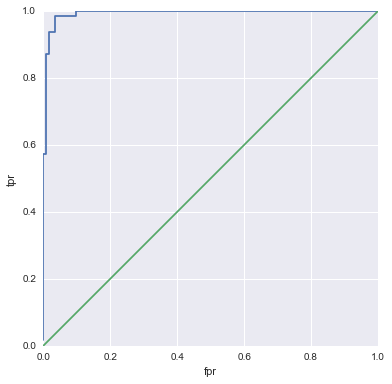

In [22]:
fpr, tpr, _ = metrics.roc_curve(y_test, probs[:, 1])

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))


mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

mpl_fig.set_figwidth(6)
mpl_fig.set_figheight(6)

ax.plot(df['fpr'],df['tpr'])
ax.plot([0,1],[0,1])
ax.set_xlabel('fpr')
ax.set_ylabel('tpr')
plt.savefig('ROCcurve.pdf', bbox_inches='tight')
#p = ggplot(df, aes(x='fpr', y='tpr')) + geom_line() 
#p + geom_abline(intercept=0,slope=1) + geom_line() 
#p + geom_vline(xintercept=0.5)
#ggsave('ROCcurve.pdf', bbox_inches='tight')

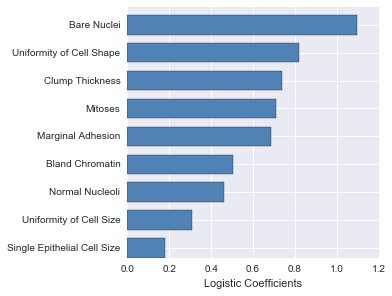

In [23]:
coefs = lin_model.coef_[0]
sorted_coefs = coefs[np.argsort(coefs)]
sorted_vars = X.columns[np.argsort(coefs)]
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
width = 0.7
mpl_fig.set_figwidth(4.5)
mpl_fig.set_figheight(4.5)
ind = np.arange(len(sorted_coefs))
p1 = ax.barh(ind, sorted_coefs, width,color=(80.0/256, 131.0/256, 182.0/256))
ax.set_xlabel('Logistic Coefficients')
#ax.set_xlabel('Number of loans')
#ax.set_title('Number of loans')

ax.set_yticks(ind + width/2.)
ax.set_xticks(np.arange(0.0, 1.201, 0.2))
ax.set_yticklabels(sorted_vars)


## Predict using Random Forest
- Random forest is potentially a great model choice as it copes well with non-linearities in the data without loosing too much interpretability.
- Predicts whether a cell is benign or not really well (Accuracy 95%, Area under ROC-curve: 0.98)
- We extract most important features
- Possible futher analysis: We can balance precision/recall dependent on whether false positives or false negatives are worse.

In [24]:
forest_model = ensemble.RandomForestClassifier()

In [25]:
forest_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
y_predicted = forest_model.predict(X_test)

In [27]:
y_predicted

array([ 0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,
        1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,
        0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,
        1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.])

In [28]:
probs = forest_model.predict_proba(X_test)

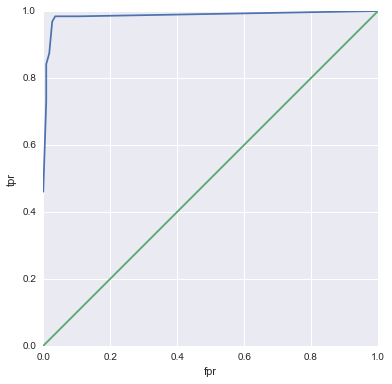

In [29]:
fpr, tpr, _ = metrics.roc_curve(y_test, probs[:,1])

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))


mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

mpl_fig.set_figwidth(6)
mpl_fig.set_figheight(6)

ax.plot(df['fpr'],df['tpr'])
ax.plot([0,1],[0,1])
ax.set_xlabel('fpr')
ax.set_ylabel('tpr')

In [30]:
y_predicted

array([ 0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,
        1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,
        0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,
        1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
        0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.])

In [31]:
print "Accuracy on test set is: " + str(metrics.accuracy_score(y_test, y_predicted))
print "Precision is: " + str(metrics.precision_score(y_test, y_predicted))
print "Recall is: " + str(metrics.recall_score(y_test, y_predicted))
print "Area under ROC-curve is: " + str(metrics.roc_auc_score(y_test, probs[:, 1]))

Accuracy on test set is: 0.971428571429
Precision is: 0.953125
Recall is: 0.968253968254
Area under ROC-curve is: 0.985969387755


In [32]:
type(X.columns)

pandas.indexes.base.Index

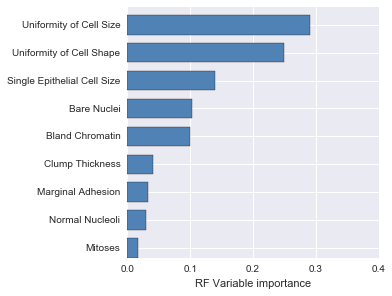

In [33]:
importances = forest_model.feature_importances_
sorted_importances = importances[np.argsort(importances)]
sorted_vars = X.columns[np.argsort(importances)]
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
width = 0.7
mpl_fig.set_figwidth(4.5)
mpl_fig.set_figheight(4.5)
ind = np.arange(len(importances))
p1 = ax.barh(ind, sorted_importances, width,color=(80.0/256, 131.0/256, 182.0/256))
ax.set_xlabel('RF Variable importance')
#ax.set_xlabel('Number of loans')
#ax.set_title('Number of loans')

ax.set_yticks(ind + width/2.)
ax.set_xticks(np.arange(0.0, 0.401, 0.1))
ax.set_yticklabels(sorted_vars)


## Predict using Linear SVM
- SVM can potentially give better results than logistic regression or random forest
- In this case it has similar performance and so we could use either

In [34]:
svm_model = svm.LinearSVC()
svm_model.fit(X_train,y_train)
y_predicted = svm_model.predict(X_test)
#probs = svm_model.predict_proba(X_test)

In [35]:
print "Accuracy on test set is: " + str(metrics.accuracy_score(y_test, y_predicted))
print "Precision is: " + str(metrics.precision_score(y_test, y_predicted))
print "Recall is: " + str(metrics.recall_score(y_test, y_predicted))
print "Area under ROC-curve is: " + str(metrics.roc_auc_score(y_test, probs[:, 1]))

Accuracy on test set is: 0.96
Precision is: 0.9375
Recall is: 0.952380952381
Area under ROC-curve is: 0.985969387755


## Vizualization of the data
- We note that any pair of the 4 most predictive variables seperates the features really well.
- The higher score of the 'Bare Nuclei', 'Uniformity of Cell Shape', 'Normal Nucleoli' and 'Uniformity of Cell Size' the higher the chance that the cell is malignant.

In [36]:
# Spread out the points at (x,y) to any point (x+x_rand,y+y_rand) where x_rand,y_rand are picked randomly on [0,1]
X_benign = X[y==0]
X_malignant = X[y==1]
X_benign_BC_scattered = X_benign['Bare Nuclei']+np.random.rand(len(X_benign['Bare Nuclei']))
X_malignant_BC_scattered = X_malignant['Bare Nuclei']+np.random.rand(len(X_malignant['Bare Nuclei']))

X_benign_UoCSh_scattered = X_benign['Uniformity of Cell Shape']+np.random.rand(len(X_benign['Uniformity of Cell Shape']))
X_malignant_UoCSh_scattered = X_malignant['Uniformity of Cell Shape']+np.random.rand(len(X_malignant['Uniformity of Cell Shape']))

X_benign_NN_scattered = X_benign['Normal Nucleoli']+np.random.rand(len(X_benign['Normal Nucleoli']))
X_malignant_NN_scattered = X_malignant['Normal Nucleoli']+np.random.rand(len(X_malignant['Normal Nucleoli']))

X_benign_UoCSi_scattered = X_benign['Uniformity of Cell Size']+np.random.rand(len(X_benign['Uniformity of Cell Size']))
X_malignant_UoCSi_scattered = X_malignant['Uniformity of Cell Size']+np.random.rand(len(X_malignant['Uniformity of Cell Size']))


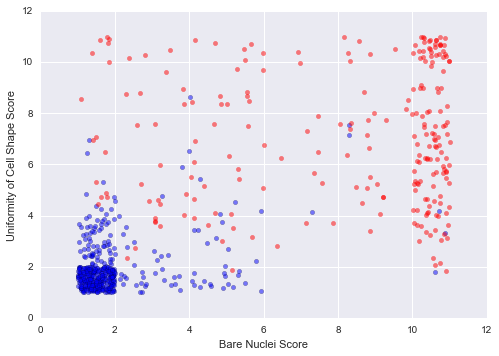

In [37]:
plt.scatter(X_benign_BC_scattered,X_benign_UoCSh_scattered, alpha=0.5)
plt.scatter(X_malignant_BC_scattered,X_malignant_UoCSh_scattered,color='red', alpha=0.5)
plt.xlabel('Bare Nuclei Score')
plt.ylabel('Uniformity of Cell Shape Score')

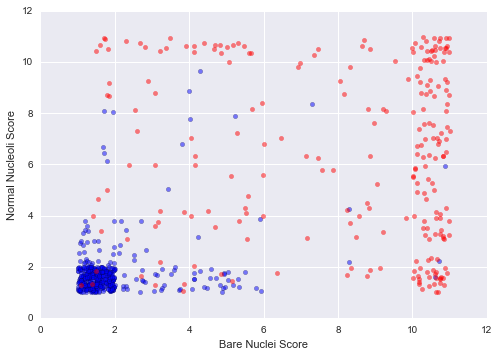

In [38]:
plt.scatter(X_benign_BC_scattered,X_benign_NN_scattered, alpha=0.5)
plt.scatter(X_malignant_BC_scattered,X_malignant_NN_scattered,color='red', alpha=0.5)
plt.xlabel('Bare Nuclei Score')
plt.ylabel('Normal Nucleoli Score')

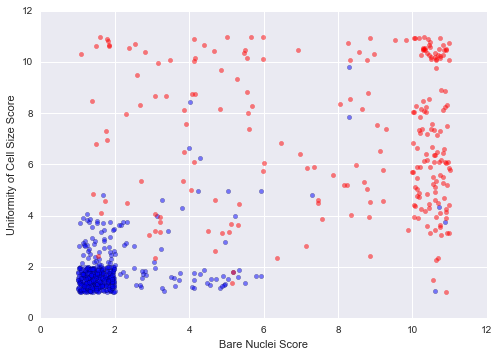

In [39]:
plt.scatter(X_benign_BC_scattered,X_benign_UoCSi_scattered, alpha=0.5)
plt.scatter(X_malignant_BC_scattered,X_malignant_UoCSi_scattered,color='red', alpha=0.5)
plt.xlabel('Bare Nuclei Score')
plt.ylabel('Uniformity of Cell Size Score')

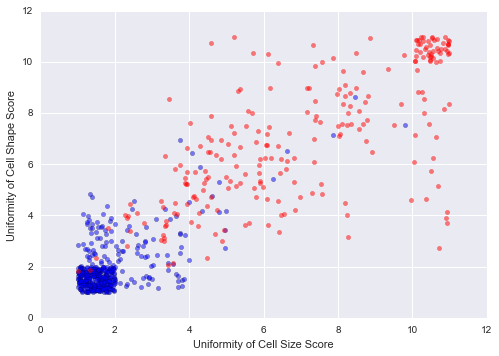

In [40]:
plt.scatter(X_benign_UoCSi_scattered,X_benign_UoCSh_scattered, alpha=0.5)
plt.scatter(X_malignant_UoCSi_scattered,X_malignant_UoCSh_scattered,color='red', alpha=0.5)
plt.xlabel('Uniformity of Cell Size Score')
plt.ylabel('Uniformity of Cell Shape Score')

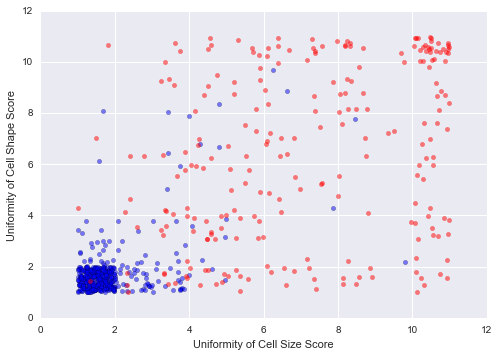

In [41]:
plt.scatter(X_benign_UoCSi_scattered,X_benign_NN_scattered, alpha=0.5)
plt.scatter(X_malignant_UoCSi_scattered,X_malignant_NN_scattered,color='red', alpha=0.5)
plt.xlabel('Uniformity of Cell Size Score')
plt.ylabel('Uniformity of Cell Shape Score')

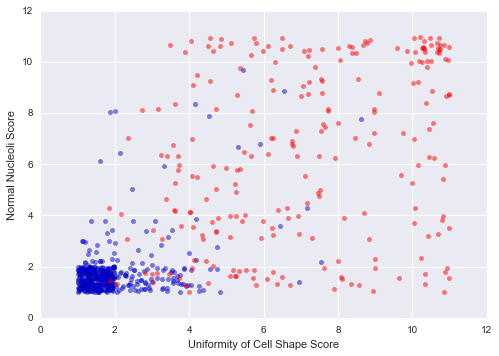

In [42]:
plt.scatter(X_benign_UoCSh_scattered,X_benign_NN_scattered, alpha=0.5)
plt.scatter(X_malignant_UoCSh_scattered,X_malignant_NN_scattered,color='red', alpha=0.5)
plt.xlabel('Uniformity of Cell Shape Score')
plt.ylabel('Normal Nucleoli Score')